In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import datetime

In [3]:
customers = pd.read_csv("/content/drive/MyDrive/Customers.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Transactions.csv")
products=pd.read_csv("/content/drive/MyDrive/Products.csv")


ct = pd.merge(customers, transactions, on="CustomerID", how="inner")
df=pd.merge(ct,products,on="ProductID",how="inner")

In [4]:
df

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 3:12:55,2,114.60,57.30,SoundWave Cookbook,Books,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 9:01:18,3,412.62,137.54,HomeSense Wall Art,Home Decor,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 0:01:00,2,614.94,307.47,SoundWave Headphones,Electronics,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 3:11:44,2,911.44,455.72,ActiveWear Smartwatch,Electronics,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,TechPro Headphones,Electronics,433.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 3:05:50,4,868.20,217.05,HomeSense T-Shirt,Clothing,217.05
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70,ActiveWear Smartphone,Electronics,239.70
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96,HomeSense Desk Lamp,Home Decor,156.96
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 9:50:48,4,1665.60,416.40,TechPro Cookbook,Books,416.40


In [ ]:
df.drop('Price_y', axis=1, inplace=True)
df.rename(columns={'Price_x': 'Price'}, inplace=True)

##Task-1 EDA

###High-transaction customers

In [ ]:
loyal=df.groupby('CustomerID')['TransactionID'].count().sort_values(ascending=False).head(10)
loyal_customers=loyal.index.to_list()
loyal_customers

['C0156',
 'C0109',
 'C0175',
 'C0141',
 'C0065',
 'C0008',
 'C0084',
 'C0075',
 'C0165',
 'C0147']

In [ ]:
df.groupby('CustomerID')['TransactionID'].count().mean()

5.025125628140704

In [ ]:
loyal

,TransactionID
CustomerID,
C0156,11
C0109,11
C0175,10
C0141,10
C0065,10
C0008,10
C0084,9
C0075,9
C0165,9


In [ ]:
df[df['CustomerID'].isin(loyal_customers)][['CustomerID', 'Region']].drop_duplicates()


,CustomerID,Region
31,C0008,North America
308,C0065,North America
358,C0075,Europe
397,C0084,Asia
540,C0109,North America
687,C0141,Europe
722,C0147,South America
767,C0156,North America
822,C0165,South America
877,C0175,Asia


###Mean Order Value

In [ ]:
df['TotalValue'].mean()

689.9955600000001

In [ ]:
df.groupby('Region')['TotalValue'].mean()

,TotalValue
Region,
Asia,697.591606
Europe,710.489872
North America,624.235246
South America,721.554474


###Average difference between Signup and TransactionDate

In [ ]:
df["SignupDate"] = pd.to_datetime(df["SignupDate"])
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

first_transaction = df.groupby("CustomerID")["TransactionDate"].min().reset_index()

customer_signup = df[["CustomerID", "SignupDate"]].drop_duplicates()
merged = pd.merge(customer_signup, first_transaction, on="CustomerID")

merged["ConversionTime"] = (merged["TransactionDate"] - merged["SignupDate"]).dt.days

average_conversion_time = merged["ConversionTime"].mean()

In [ ]:
average_conversion_time

228.75879396984925

In [ ]:
merged[merged["ConversionTime"]<0]

,CustomerID,SignupDate,TransactionDate,ConversionTime
2,C0003,2024-03-07,2024-02-18 02:50:37,-18
11,C0012,2024-08-07,2024-05-12 12:53:40,-87
12,C0013,2024-05-19,2024-02-24 20:08:07,-85
13,C0014,2024-06-22,2024-01-17 18:31:55,-157
17,C0018,2024-09-21,2024-02-17 18:50:52,-217
...,...,...,...,...
181,C0183,2024-01-23,2024-01-08 13:41:10,-15
185,C0187,2024-08-02,2024-01-09 11:36:08,-206
188,C0190,2024-05-31,2024-05-16 09:05:38,-15
192,C0194,2024-05-04,2024-03-14 11:55:39,-51


In [ ]:
merged[merged["ConversionTime"]<0]['ConversionTime'].mean()

-156.32258064516128

###Retention rate

In [ ]:
quarterly_customers = df.groupby('Quarter')['CustomerID'].unique()

retention = {}

quarters = list(quarterly_customers.index)

for i in range(1, len(quarters)):
    current_quarter = quarters[i]
    previous_quarter = quarters[i - 1]

    retained_customers = set(quarterly_customers[current_quarter]) & set(quarterly_customers[previous_quarter])

    retention[current_quarter] = (len(retained_customers) / len(quarterly_customers[previous_quarter])) * 100

retention_df = pd.DataFrame(list(retention.items()), columns=['Quarter', 'RetentionRate'])
retention_df

,Quarter,RetentionRate
0,Q2,75.172414
1,Q3,65.100671
2,Q4,72.388060


In [ ]:
retention_df['RetentionRate'].mean()

70.88704821184518

In [ ]:
df['Month'] = df['TransactionDate'].dt.to_period('M')  # Ensure that you extract the month correctly
monthly_customers = df.groupby('Month')['CustomerID'].unique()

monthly_retention = {}

months = list(monthly_customers.index)

for i in range(2, len(months)):
    current_month = months[i]
    previous_month = months[i - 1]

    retained_customers = set(monthly_customers[current_month]) & set(monthly_customers[previous_month])

    monthly_retention[current_month] = (len(retained_customers) / len(monthly_customers[previous_month])) * 100

monthly_retention_df = pd.DataFrame(list(monthly_retention.items()), columns=['Month', 'RetentionRate'])

monthly_retention_df

,Month,RetentionRate
0,2024-02,27.710843
1,2024-03,37.878788
2,2024-04,24.615385
3,2024-05,30.000000
4,2024-06,28.358209
5,2024-07,43.333333
6,2024-08,37.500000
7,2024-09,33.333333
8,2024-10,28.767123
9,2024-11,20.000000


In [ ]:
monthly_retention_df['RetentionRate'].mean()

31.100841788653398

In [ ]:
first_month_customers = set(monthly_customers[months[0]])
last_month_customers = set(monthly_customers[months[-1]])

overall_retained_customers = first_month_customers & last_month_customers

overall_retention_rate = (len(overall_retained_customers) / len(first_month_customers)) * 100

print(f"Overall Retention Rate: {overall_retention_rate:.2f}%")


Overall Retention Rate: 25.00%


###Top-selling products and least selling products

In [ ]:
df['ProductName'].value_counts()

,count
ProductName,
ActiveWear Smartwatch,40
SoundWave Headphones,38
BookWorld Biography,30
SoundWave Cookbook,29
ActiveWear Rug,29
...,...
SoundWave Bluetooth Speaker,7
BookWorld Wall Art,7
SoundWave Laptop,7


In [ ]:
top_5_products=df.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(5)
top_5_products.index.to_list()

['ActiveWear Smartwatch',
 'SoundWave Headphones',
 'SoundWave Novel',
 'ActiveWear Jacket',
 'ActiveWear Rug']

In [ ]:
bottom_5_products=df.groupby('ProductName')['TotalValue'].sum().sort_values().head(5)
bottom_5_products.index.to_list()

['ComfortLiving Laptop',
 'ActiveWear T-Shirt',
 'ComfortLiving Rug',
 'SoundWave Bluetooth Speaker',
 'ComfortLiving Desk Lamp']

###Quarterly sales region

In [ ]:
def assign_quarter(date):
    if datetime.date(2023, 12, 30) <= date <= datetime.date(2024, 3, 31):
        return 'Q4'
    elif datetime.date(2024, 4, 1) <= date <= datetime.date(2024, 6, 30):
        return 'Q1'
    elif datetime.date(2024, 7, 1) <= date <= datetime.date(2024, 9, 30):
        return 'Q2'
    elif datetime.date(2024, 10, 1) <= date <= datetime.date(2024, 12, 31):
        return 'Q3'
    else:
        return 'Out of Range'

df['Quarter'] = df['TransactionDate'].dt.date.apply(assign_quarter)


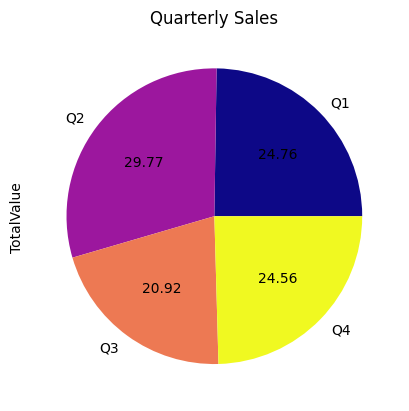

In [ ]:
quarterly_sales=df.groupby('Quarter')['TotalValue'].sum()
quarterly_sales.plot(kind='pie',autopct='%.2f',colormap='plasma')
plt.title('Quarterly Sales')
plt.show()

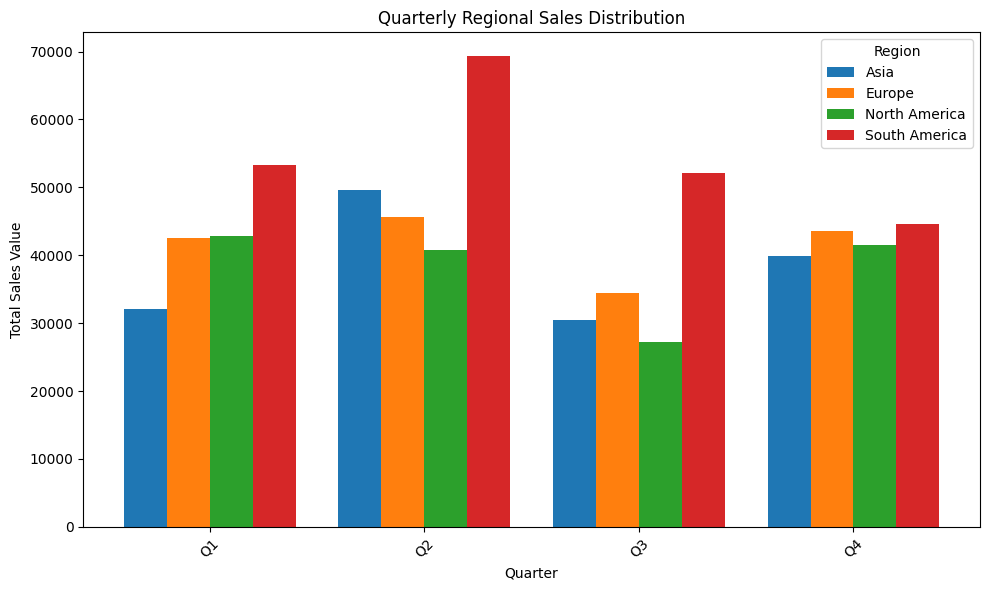

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_pivoted = df.pivot_table(index='Quarter', columns='Region', values='TotalValue', aggfunc='sum')

quarters = df_pivoted.index
regions = df_pivoted.columns
x = np.arange(len(quarters))

width = 0.2

fig, ax = plt.subplots(figsize=(10,6))

for i, region in enumerate(regions):
    ax.bar(x + i * width, df_pivoted[region], width, label=region)

ax.set_xlabel('Quarter')
ax.set_ylabel('Total Sales Value')
ax.set_title('Quarterly Regional Sales Distribution')
ax.set_xticks(x + width * (len(regions) - 1) / 2)
ax.set_xticklabels(quarters, rotation=45)
ax.legend(title='Region')
plt.tight_layout()
plt.show()


In [ ]:
df_pivoted = df.pivot_table(index='Quarter', columns='Region', values='TotalValue', aggfunc='sum')

total_sales_per_quarter = df_pivoted.sum(axis=1)

df_percentage = df_pivoted.div(total_sales_per_quarter, axis=0) * 100

print("Sales Percentage by Region for Each Quarter:")
df_percentage

Sales Percentage by Region for Each Quarter:


Region,Asia,Europe,North America,South America
Quarter,,,,
Q1,18.781729,24.930912,25.086399,31.200960
Q2,24.163748,22.235278,19.829034,33.771941
Q3,21.136122,23.859849,18.901120,36.102909
Q4,23.520203,25.707262,24.463727,26.308807


<ipython-input-36-e7cf5934183e>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(categories))  # Use 'tab10' for 10 distinct colors


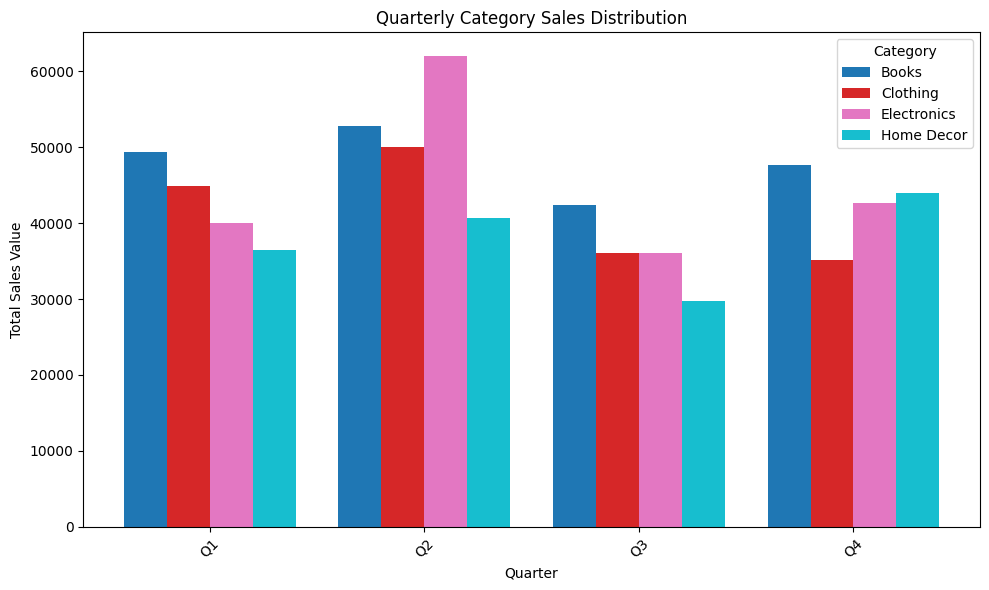

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_pivoted = df.pivot_table(index='Quarter', columns='Category', values='TotalValue', aggfunc='sum')

quarters = df_pivoted.index
categories = df_pivoted.columns
x = np.arange(len(quarters))

width = 0.2

cmap = plt.cm.get_cmap('tab10', len(categories))  # Use 'tab10' for 10 distinct colors

fig, ax = plt.subplots(figsize=(10,6))

for i, category in enumerate(categories):
    ax.bar(x + i * width, df_pivoted[category], width, label=category, color=cmap(i))

ax.set_xlabel('Quarter')
ax.set_ylabel('Total Sales Value')
ax.set_title('Quarterly Category Sales Distribution')
ax.set_xticks(x + width * (len(categories) - 1) / 2)  # Center the labels under groups
ax.set_xticklabels(quarters, rotation=45)
ax.legend(title='Category')

plt.tight_layout()
plt.show()


In [ ]:
df_pivoted = df.pivot_table(index='Quarter', columns='Category', values='TotalValue', aggfunc='sum')

total_sales_per_quarter = df_pivoted.sum(axis=1)

df_percentage = df_pivoted.div(total_sales_per_quarter, axis=0) * 100

print("Sales Percentage by Category for Each Quarter:")
df_percentage

Sales Percentage by Category for Each Quarter:


Category,Books,Clothing,Electronics,Home Decor
Quarter,,,,
Q1,28.880713,26.289955,23.455113,21.374220
Q2,25.673064,24.322111,30.190970,19.813854
Q3,29.375747,25.025948,25.016034,20.582272
Q4,28.140630,20.764291,25.140351,25.954728


In [ ]:
df_pivoted = df.pivot_table(index='Region', columns='Category', values='TotalValue', aggfunc='sum')

total_sales_per_quarter = df_pivoted.sum(axis=1)

df_percentage = df_pivoted.div(total_sales_per_quarter, axis=0) * 100

print("Sales Percentage by Category for Each RegionS:")
df_percentage

Sales Percentage by Category for Each Region:


Category,Books,Clothing,Electronics,Home Decor
Region,,,,
Asia,21.778094,32.453132,23.447744,22.321030
Europe,28.549232,21.855385,24.999364,24.596019
North America,27.451288,24.973830,29.358172,18.216710
South America,31.799050,19.349439,26.827278,22.024233


###High value customers

In [ ]:
customer_spending = df.groupby('CustomerID')['TotalValue'].sum().reset_index()

customer_spending.columns = ['CustomerID', 'Total_Spent']
customer_spending['Total_Spent'].mean()

3467.314371859297

In [ ]:
top_spenders = customer_spending.sort_values(by='Total_Spent', ascending=False).head(10)
top_spenders

,CustomerID,Total_Spent
140,C0141,10673.87
53,C0054,8040.39
64,C0065,7663.70
155,C0156,7634.45
81,C0082,7572.91
186,C0188,7111.32
58,C0059,7073.28
27,C0028,6819.57
98,C0099,6715.72
164,C0165,6708.10


In [ ]:
top_spenders['CustomerID'].to_list()

['C0141',
 'C0054',
 'C0065',
 'C0156',
 'C0082',
 'C0188',
 'C0059',
 'C0028',
 'C0099',
 'C0165']

###Day-wise Analysis

In [18]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Day'] = df['TransactionDate'].dt.day_name()
df

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,Day
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,SoundWave Cookbook,Books,57.30,Friday
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,HomeSense Wall Art,Home Decor,137.54,Tuesday
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,SoundWave Headphones,Electronics,307.47,Monday
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,ActiveWear Smartwatch,Electronics,455.72,Tuesday
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,TechPro Headphones,Electronics,433.64,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 03:05:50,4,868.20,217.05,HomeSense T-Shirt,Clothing,217.05,Wednesday
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70,ActiveWear Smartphone,Electronics,239.70,Saturday
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96,HomeSense Desk Lamp,Home Decor,156.96,Monday
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 09:50:48,4,1665.60,416.40,TechPro Cookbook,Books,416.40,Tuesday


In [15]:
daywise_transaction_count = df.groupby('Day')['TransactionID'].count().sort_index()
daywise_transaction_count=daywise_transaction_count.sort_values(ascending=False)
daywise_transaction_count

,TransactionID
Day,
Tuesday,163
Wednesday,158
Thursday,150
Monday,139
Sunday,139
Saturday,126
Friday,125


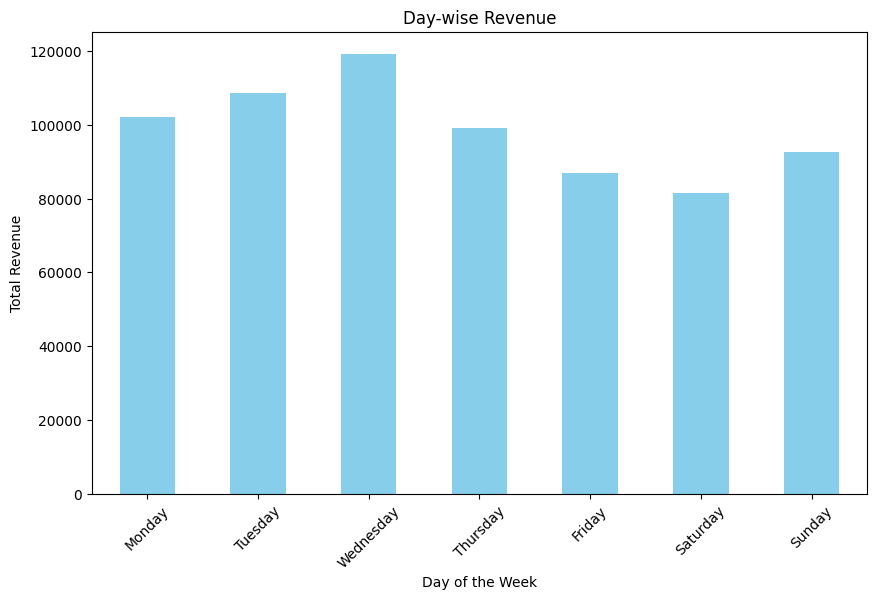

In [19]:
daywise_revenue = df.groupby('Day')['TotalValue'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
daywise_revenue.plot(kind='bar', color='skyblue')
plt.title('Day-wise Revenue')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

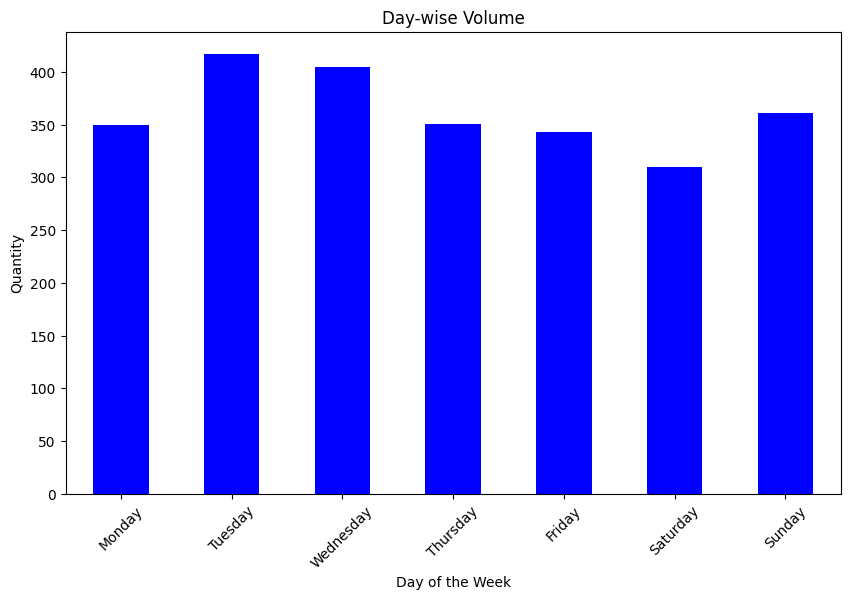

In [22]:
daywise_revenue = df.groupby('Day')['Quantity'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 6))
daywise_revenue.plot(kind='bar', color='blue')
plt.title('Day-wise Volume')
plt.xlabel('Day of the Week')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

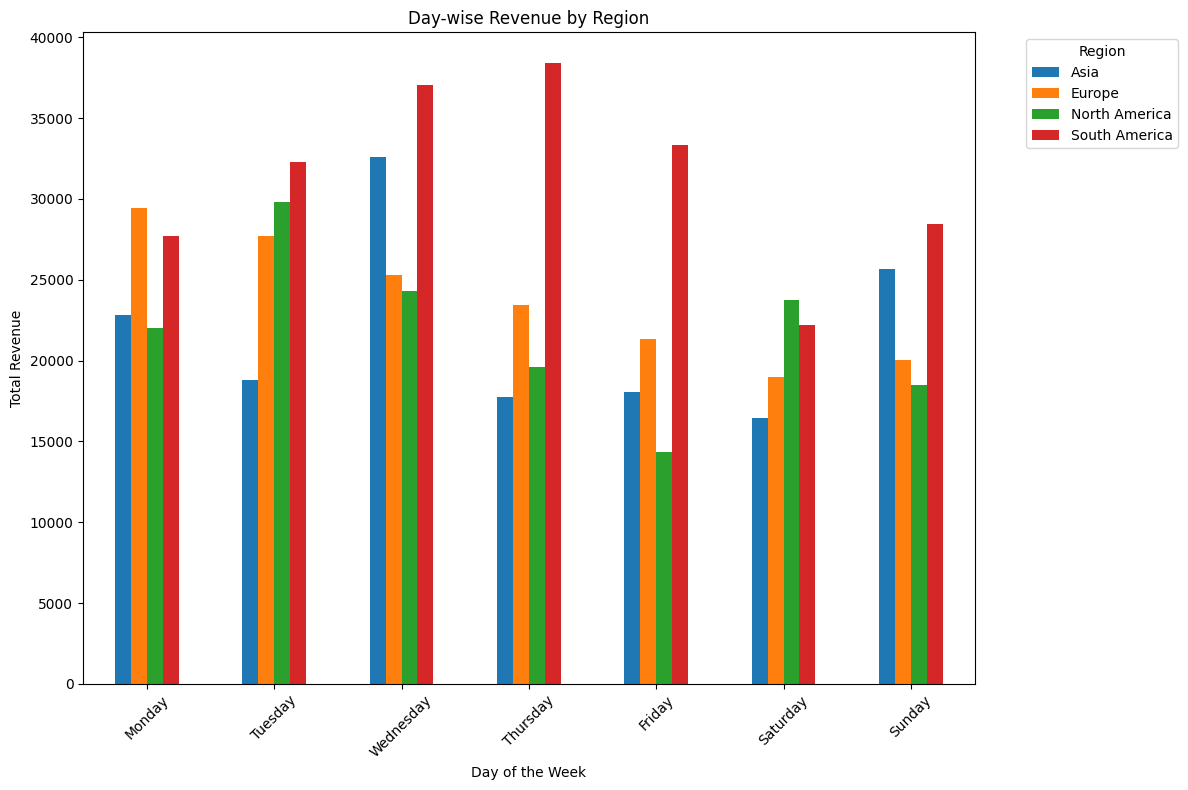

In [25]:
region_daywise_revenue = df.groupby(['Day', 'Region'])['TotalValue'].sum().unstack(fill_value=0)

region_daywise_revenue = region_daywise_revenue.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

region_daywise_revenue.plot(kind='bar', figsize=(12, 8))

plt.title('Day-wise Revenue by Region')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
region_daywise_revenue = df.groupby(['Day', 'Region'])['TotalValue'].sum().unstack(fill_value=0)

region_daywise_revenue = region_daywise_revenue.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

region_daywise_percentage = region_daywise_revenue.div(region_daywise_revenue.sum(axis=1), axis=0) * 100
region_daywise_percentage


Region,Asia,Europe,North America,South America
Day,,,,
Monday,22.400422,28.873867,21.574403,27.151308
Tuesday,17.293353,25.503804,27.458392,29.744451
Wednesday,27.333858,21.205161,20.390795,31.070186
Thursday,17.869159,23.652227,19.780921,38.697693
Friday,20.742797,24.528918,16.453092,38.275193
Saturday,20.205605,23.324399,29.201875,27.268121
Sunday,27.693000,21.644445,19.956141,30.706414


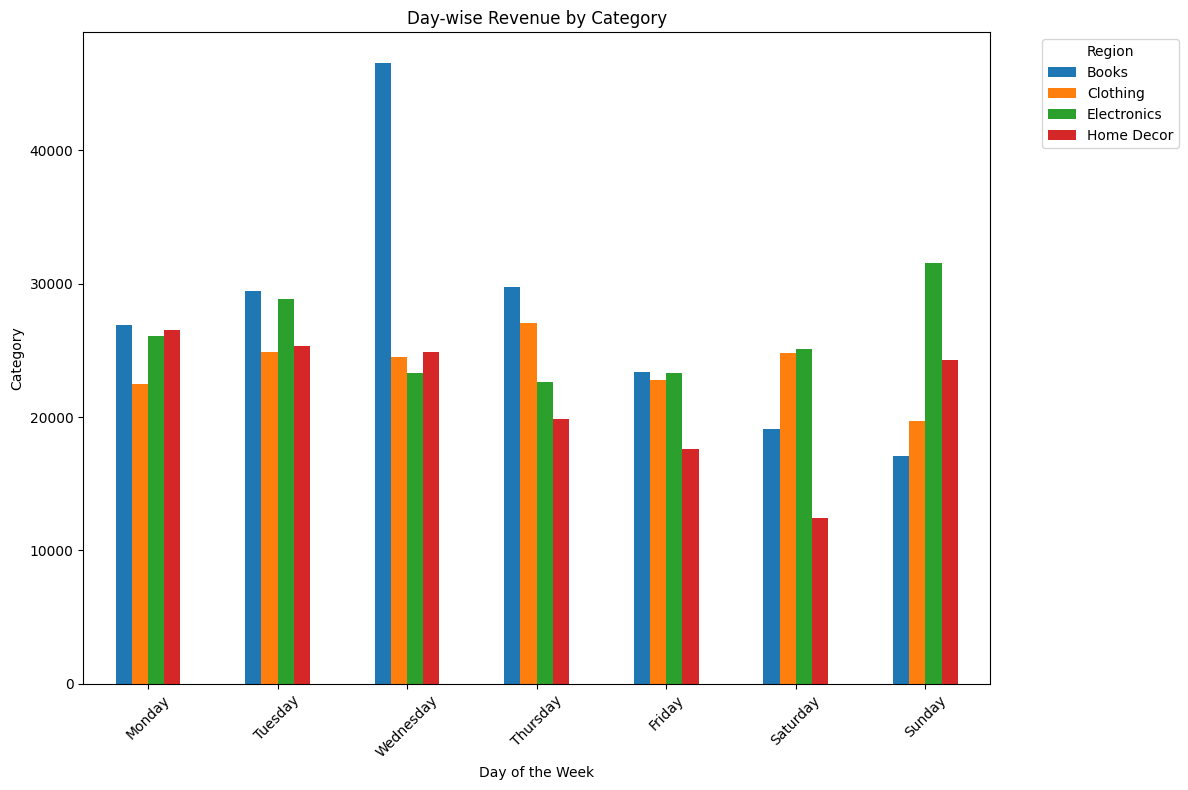

In [29]:
region_daywise_revenue = df.groupby(['Day', 'Category'])['TotalValue'].sum().unstack(fill_value=0)

region_daywise_revenue = region_daywise_revenue.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

region_daywise_revenue.plot(kind='bar', figsize=(12, 8))

plt.title('Day-wise Revenue by Category')
plt.xlabel('Day of the Week')
plt.ylabel('Category Count')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [30]:
category_daywise_revenue = df.groupby(['Day', 'Category'])['TotalValue'].sum().unstack(fill_value=0)

category_daywise_revenue = category_daywise_revenue.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

category_daywise_percentage = category_daywise_revenue.div(category_daywise_revenue.sum(axis=1), axis=0) * 100
category_daywise_percentage


Category,Books,Clothing,Electronics,Home Decor
Day,,,,
Monday,26.386809,22.024982,25.578410,26.009800
Tuesday,27.123108,22.946024,26.589302,23.341566
Wednesday,39.016972,20.562678,19.572536,20.847813
Thursday,29.972578,27.253731,22.775285,19.998405
Friday,26.849235,26.137646,26.744354,20.268765
Saturday,23.464055,30.445183,30.852457,15.238304
Sunday,18.443689,21.292848,34.031719,26.231743
